## Importing packages

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from numpy.random import random, seed
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import itertools

# Part 1: Analysis of methods with the Franke function

### Defining functions

In [89]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def RegressionSigma2 (yobs,ypred,n_params):
    n = yobs.shape[0]
    return np.sum((yobs-ypred)**2)/(n-n_params)

def create_X(x, y, n=1 ):
    '''from x, y meshgrid vectors computes the design matrix for a polynomial model of degree n.'''
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    
    for i in range(1,n+1):
        #starting from the index after the i-1 degree
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            #combinations of powers of x and y, starting from x**i
            X[:,q+k] = (x**(i-k))*(y**k)
            
    # The design matrix is set up as 1,x,y,x**2,x*y,y**2
    return X


def OLS(X_train, X_test, z_train):
    '''
    Fit with OLS regression using the train set and 
    returns the predicted values for both the train and the test set.
    '''
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # # Apply the transform to both the training set and the test set

    
    z_train =np.asarray(z_train)                  # Series to array
    z_train = z_train.reshape(len(z_train),1)     # Reshape because standard scaler expects 2D

    target_scaler = StandardScaler()
    target_scaler.fit(z_train)
    z_train= target_scaler.transform(z_train)

    #extract regression coefficients
    beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train
    
    #predict train and test values
    z_train_tilde_ols = X_train@beta_ols
    z_test_tilde_ols = X_test@beta_ols
    
    # Do the inverse transformation to compare the targets and find the MSE
        
    z_train = target_scaler.inverse_transform(z_train)
    z_train_tilde_ols = target_scaler.inverse_transform(z_train_tilde_ols)
    z_test_tilde_ols = target_scaler.inverse_transform(z_test_tilde_ols)
    
    return np.ravel(z_train_tilde_ols), np.ravel(z_test_tilde_ols)


def Ridge(X_train,X_test,z_train,z_test,lambd):
    '''
    Fit with Ridge regression using the train set and 
    returns the predicted values for both the train and the test set.
    '''

    # Since it relates to remove intercepts, better to use built in function in SKL
    RegRidge = linear_model.Ridge(lambd,fit_intercept= True)
    
    # Scaling
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # # Apply the transform to both the training set and the test set

    
    z_train =np.asarray(z_train)                  # Series to array
    z_train = z_train.reshape(len(z_train),1)     # Reshape because standard scaler expects 2D

    target_scaler = StandardScaler()
    target_scaler.fit(z_train)
    z_train= target_scaler.transform(z_train)
    
    #fit the model to the training data
    RegRidge.fit(X_train,z_train)
    
    # and then make the prediction
    z_tilde_train = RegRidge.predict(X_train)
    z_tilde_test = RegRidge.predict(X_test)
    
    # Do the inverse transformation to compare the targets and find the MSE
        
    z_train = target_scaler.inverse_transform(z_train)              # Not necessary because we dont compute MSE here
    z_tilde_train = target_scaler.inverse_transform(z_tilde_train)
    z_tilde_test = target_scaler.inverse_transform(z_tilde_test)
    
    return z_tilde_train, z_tilde_test

def bootstrap_OLS(X_train, X_test, z_train, z_test, n_bootstrap): 
    MSE = np.zeros((n_bootstrap,2))
    n = len(z_train)
    z_tilde_train_ols = np.empty((len(z_train), n_bootstrap))
    z_tilde_test_ols = np.empty((len(z_test), n_bootstrap))
    for i in range(n_bootstrap):
        sequence = np.random.randint(0,n,n)
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]  
        z_tilde_train_ols[:,i] , z_tilde_test_ols[:,i] = OLS(X1_train, X_test, z1_train)
        MSE[i,0] = mean_squared_error(z1_train,z_tilde_train_ols[:,i]) 
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test_ols[:,i])  
    return z_tilde_train_ols, z_tilde_test_ols, MSE
# From now on, index 0 corresponds to train and 1 to test

def bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, lambd): 
    n = len(z_train)
    #prepare arrays for output
    MSE = np.zeros((n_bootstrap,2))

    
    z_tilde_train_aux = np.empty(n)
    z_tilde_test_aux = np.empty(n)
    
    
    
    #cycle on resamplings
    for i in range(n_bootstrap):
        
        #extract sequence for resampling
        sequence = np.random.randint(0,n,n)
        
        #resampled arrays
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]
        
        #fit and predict
        z_tilde_train_aux , z_tilde_test_aux = Ridge(X1_train, X_test, z1_train, z_test, lambd)
        
        #calculate mse on train and test
        MSE[i,0] = mean_squared_error(z1_train,z_tilde_train_aux)
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test_aux)
    
        
    return z_tilde_train_aux, z_tilde_test_aux, MSE

def cross_validation_OLS(k_folds, X, z):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]
        
        X_test = X[test_inds]
        z_test = z[test_inds]
        
        z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train)
        
        MSE_train.append(mean_squared_error(z_train, z_train_tilde_ols))
        MSE_test.append(mean_squared_error(z_test, z_test_tilde_ols))
        
    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    return MSE_train_mean, MSE_test_mean

def cross_validation_Ridge(k_folds, X, z, lambd):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)

    for train_inds, test_inds in kfold.split(X):
        
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        z_train_tilde_Ridge, z_test_tilde_Ridge = Ridge( X_train, X_test, z_train, z_test, lambd)
        
        MSE_train.append(mean_squared_error(z_train, z_train_tilde_Ridge))
        MSE_test.append(mean_squared_error(z_test, z_test_tilde_Ridge))

    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    
    return MSE_train_mean, MSE_test_mean






## Create Franke function data set

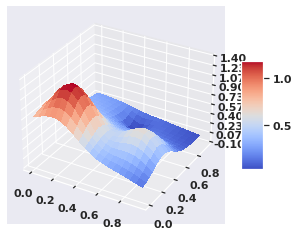

In [90]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


## OLS 

In [91]:
#number of points for each axis
n_points = 30

#set random seed
np.random.seed(53186)
x0 = np.random.rand(n_points)

#set random seed
np.random.seed(48643)
y0 = np.random.rand(n_points)

#mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

#create a dummy design matrix for the arrays of x and y
X0 = create_X(x,y)

#generate normal distributed noise 
noise_amp = 0.3
noise = noise_amp*np.random.randn(X0.shape[0])

#calculate starting target values with noise
z = FrankeFunction(X0[:,1],X0[:,2]) + noise


# The degree of the polynomial and the corresponding design matrix will be specific of each problem

par 0: 0.2 +/- 0.2 (95%)
par 1: 15.4 +/- 2.0 (95%)
par 2: 2.8 +/- 1.9 (95%)
par 3: -74.7 +/- 11.0 (95%)
par 4: -13.7 +/- 6.7 (95%)
par 5: -6.1 +/- 9.7 (95%)
par 6: 131.9 +/- 25.8 (95%)
par 7: 54.0 +/- 15.1 (95%)
par 8: 9.8 +/- 14.6 (95%)
par 9: -11.3 +/- 22.2 (95%)
par 10: -100.1 +/- 27.2 (95%)
par 11: -75.0 +/- 17.2 (95%)
par 12: 8.6 +/- 14.2 (95%)
par 13: -27.4 +/- 16.8 (95%)
par 14: 33.5 +/- 23.4 (95%)
par 15: 27.7 +/- 10.6 (95%)
par 16: 28.2 +/- 7.9 (95%)
par 17: 10.4 +/- 7.0 (95%)
par 18: -14.9 +/- 6.4 (95%)
par 19: 19.7 +/- 7.7 (95%)
par 20: -18.9 +/- 9.2 (95%)
The MSE test for OLS and degree without scale  5
0.09581210498775647
The MSE test for OLS and degree  5
0.09581210498636274
MSE with intercept column from SKL
0.09581210498775647
The MSE train for OLS and degree  5
0.08521747696991351
R2 scores for 
Test  0.5441952728008821
Train 0.5622991060806743


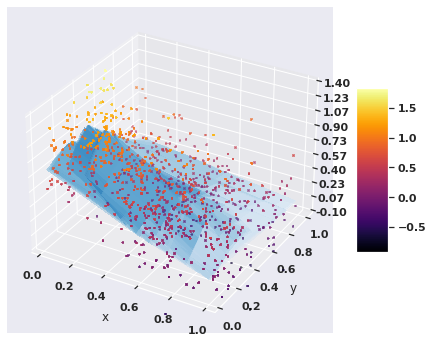

In [92]:
# THIS IS THE FIT CONSIDERING THE INTERCEPT (Intercept included in design matrix)


#degree of the polynomial
maxdegree = 5

#setup design matrix with polynomial model
X = create_X(x,y,maxdegree)


#split train and test set
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=2)


z_train_tilde_ols, z_test_tilde_ols = OLS(X_train, X_test, z_train)
# Intercept is included in the design matrix
skl = LinearRegression(fit_intercept=False).fit(X_train, z_train)

zpredictSKL = skl.predict(X_test)

#apply OLS regression

beta = skl.coef_

#variance of the target data
sigma2 = RegressionSigma2(z_train,z_train_tilde_ols,beta.shape[0])

#calculate covariance matrix of parameters
CovBeta = np.linalg.pinv(X.T @ X)
StdBeta = np.sqrt(sigma2*np.diag(CovBeta))

#confidence intervals at 95% (Gaussian assumed for betas)

CIBeta = np.zeros((beta.shape[0],2))
CIBeta[:,0] = beta - 2*StdBeta
CIBeta[:,1] = beta + 2*StdBeta

for i in range(beta.shape[0]):
    print("par {}: {:.1f} +/- {:.1f} (95%)".format(i,beta[i],StdBeta[i]))

#Let's calculate the MSE for the unscalled data:
mse_test_Skl=mean_squared_error(z_test,zpredictSKL)

#calculate train and test mse 
mse_train = mean_squared_error(z_train,z_train_tilde_ols)
mse_test = mean_squared_error(z_test,z_test_tilde_ols)

#calculate train and test r2
r2_train = r2_score(z_train,z_train_tilde_ols)
r2_test = r2_score(z_test,z_test_tilde_ols)
print("The MSE test for OLS and degree without scale ",maxdegree)

print(mse_test_Skl)

print("The MSE test for OLS and degree ",maxdegree)
print(mse_test)

print("MSE with intercept column from SKL")
print(mean_squared_error(z_test,zpredictSKL))

print("The MSE train for OLS and degree ",maxdegree)

print(mse_train)

print("R2 scores for ")

print("Test " , r2_test)
print("Train" , r2_train)

sns.set(style = "darkgrid")

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

# Plot the surface.
surf_noise = ax.scatter3D(X[:,1],X[:,2], z, "o",c=z,cmap=cm.inferno, s=0.5,antialiased=False)
surf = ax.plot_surface(x, y, FrankeFunction(x, y),cmap="Blues", linewidth=0, antialiased=False,alpha=0.2)



# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("x")
ax.set_ylabel("y")

# Add a color bar which maps values to colors.
fig.colorbar(surf_noise, shrink=0.5, aspect=5)

plt.show()

### Changing noise and size of the data set

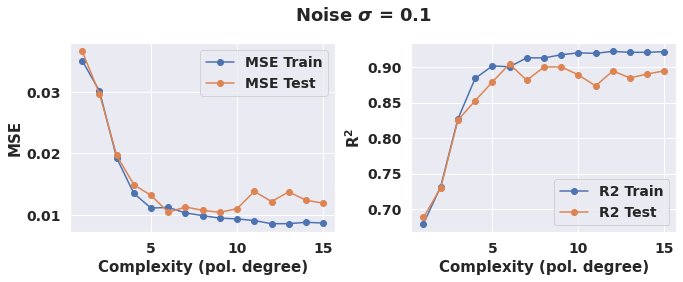

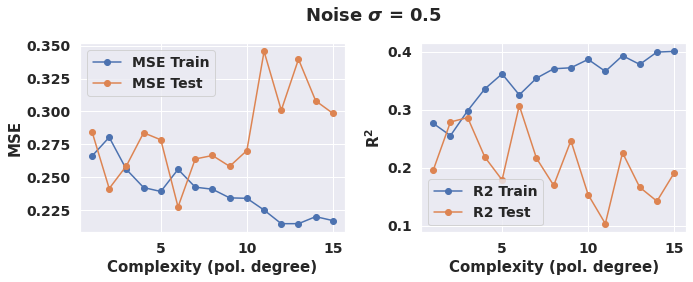

In [93]:
#std of the noise
noise_amps = [0.1,0.5]

#maximum degree of polynomial
maxdegree = 15

#create arrays for results
polydegree = np.zeros(maxdegree)
MSE_OLS = np.zeros((maxdegree,2,len(noise_amps)))
R2_OLS = np.zeros((maxdegree,2,len(noise_amps)))

matplotlib.rcParams.update({'font.size': 15,'font.weight':"bold"})
for i in range(len(noise_amps)):
    
    np.random.seed(3)
    noise = noise_amps[i]*np.random.randn(X0.shape[0])

    #calculate starting target values with noise
    z = FrankeFunction(X0[:,1],X0[:,2]) + noise

    for degree in range(maxdegree):

        X = create_X(x,y,degree+1)

        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_sc = scaler.transform(X_train)
        X_test_sc = scaler.transform(X_test)
        
        z_t = z_test.reshape(len(z_test),1)
        polydegree[degree] = degree+1

        z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train) 

        MSE_OLS[degree, 0] = mean_squared_error(z_train,z_train_tilde_ols)
        MSE_OLS[degree, 1] = mean_squared_error(z_test,z_test_tilde_ols)  

        R2_OLS[degree, 0] = r2_score(z_train,z_train_tilde_ols)
        R2_OLS[degree, 1] = r2_score(z_test,z_test_tilde_ols)  


    
    
    #plot the results
    matplotlib.rcParams['text.latex.preamble']=r'\usepackage{sfmath} \boldmath'
    matplotlib.rcParams.update({'font.size': 15,'font.weight':"bold"})
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    fig.tight_layout(pad=2.5)

    ax[0].plot(polydegree,MSE_OLS[:,0,i],"o-",label='MSE Train')
    ax[0].plot(polydegree,MSE_OLS[:,1,i],"o-",label='MSE Test',)
    ax[0].set_xlabel('Complexity (pol. degree)',size=15,fontweight='bold')
    ax[0].set_ylabel('MSE',size=15,fontweight='bold')
    ax[0].tick_params(axis='both', labelsize=14)
    ax[0].legend(prop={"size":14})

    ax[1].plot(polydegree,R2_OLS[:,0,i],"o-",label='R2 Train')
    ax[1].plot(polydegree,R2_OLS[:,1,i],"o-",label='R2 Test')
    ax[1].set_xlabel('Complexity (pol. degree)',size=15,fontweight='bold')
    ax[1].set_ylabel("$\mathbf{R^2}$",size=15)
    ax[1].tick_params(axis='both', labelsize=14)
    ax[1].legend(prop={"size":14})
    

    plt.suptitle("Noise $\sigma$ = {}".format(noise_amps[i]),fontweight='bold')

    fig.savefig("Pictures/OLS_poldegree{}.png".format(noise_amps[i]), bbox_inches='tight')


## Bootstrapping method OLS

### Bias-variance tradeoff

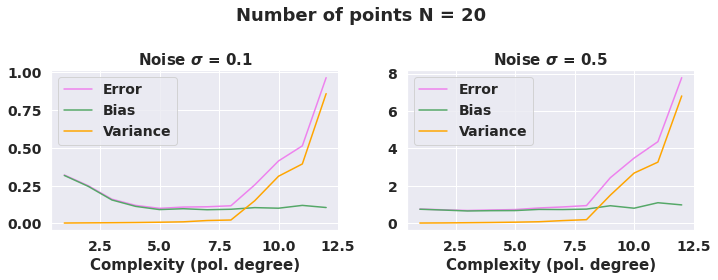

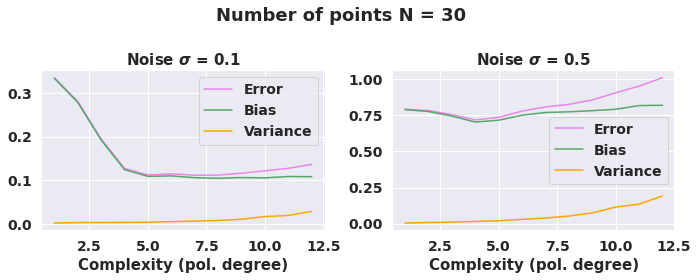

In [94]:
#size of the initial dataset
nums_points = [20,30]

#std of the noise
noise_amps = [0.1,0.5]

#maximum degree of polynomial
maxdegree = 12

#number of bootstrap resamplings
n_bs = 100



#create arrays for results
error = np.zeros((maxdegree,len(noise_amps)))
bias = np.zeros((maxdegree,len(noise_amps)))
variance = np.zeros((maxdegree,len(noise_amps)))
polydegree = np.zeros(maxdegree)
MSE_boot = np.zeros((maxdegree,2,len(noise_amps),len(nums_points)))



for j in range(len(nums_points)):
    
    fig,ax = plt.subplots(1,len(noise_amps),figsize=(10,4))
    fig.subplots_adjust(top=0.8)

    
    np.random.seed(53186)
    x0 = np.random.rand(nums_points[j])

    #set random seed
    np.random.seed(48643)
    y0 = np.random.rand(nums_points[j])

    #mesh arrays of x and y
    x,y = np.meshgrid(x0,y0)

    #create a dummy design matrix for the arrays of x and y
    X0 = create_X(x,y)
    
    
    for i in range(len(noise_amps)):

        
        np.random.seed(1231)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise

        z = z.reshape(len(z),1)

        #cycle on polynomial degrees

        for degree in range(maxdegree):

            X = create_X(x,y,degree + 1)

            # Why needed random_state
            # The random_seed makes sure we take the same indices for spliting every time, and it is necessary to test the same test set
            X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=2)
            
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train_sc = scaler.transform(X_train)
            X_test_sc = scaler.transform(X_test)
            
            target_scaler = StandardScaler()
            target_scaler.fit(z_train)
            z_train_sc = target_scaler.transform(z_train)
            z_test_sc = target_scaler.transform(z_test)
            
            #_, z_pred, mse = bootstrap_OLS(X_train, X_test, z_train, z_test, n_bs )
            #z_t = z_test.reshape(len(z_test),1)
            
            _, z_pred, mse = bootstrap_OLS(X_train_sc, X_test_sc, z_train_sc, z_test_sc, n_bs )
            z_t = z_test_sc.reshape(len(z_test_sc),1)
            polydegree[degree] = degree+1
            error[degree,i] = np.mean( np.mean((z_t - z_pred)**2, axis=1, keepdims=True) )
            bias[degree,i] = np.mean( (z_t - np.mean(z_pred, axis=1, keepdims=True))**2 )
            variance[degree,i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

            MSE_boot[degree, 0, i, j] = np.mean(mse[:,0]) 
            MSE_boot[degree, 1, i, j] = np.mean(mse[:,1])

        fig.tight_layout(h_pad=0.1,w_pad=1.5)
        ax[i].plot(polydegree, error[:,i],color="violet", label='Error')
        ax[i].plot(polydegree,bias[:,i],color="g" ,label='Bias')
        ax[i].plot(polydegree, variance[:,i],color="orange", label='Variance')
        ax[i].set_xlabel('Complexity (pol. degree)',size=15,fontweight="bold")
        ax[i].tick_params(axis='both', labelsize=14)
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        plt.setp(ax[i].title,size=15, fontweight="bold")

        
        ax[i].legend(prop={"size":14})
        plt.suptitle("Number of points N = {}".format(nums_points[j]),fontweight="bold")
        fig.savefig("Pictures/BV_OLS_{}.png".format(nums_points[j]))

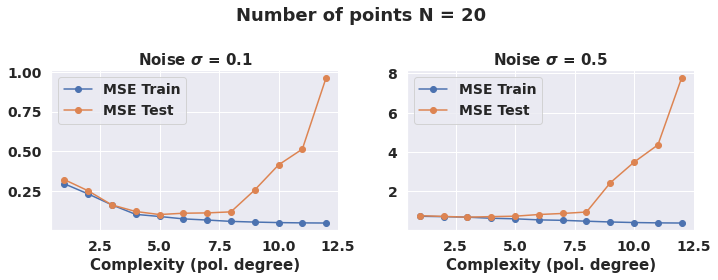

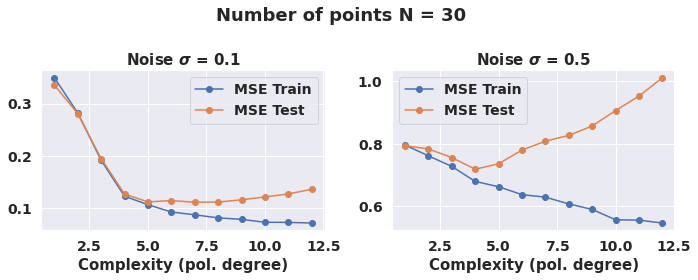

In [95]:
for j in range(len(nums_points)):
    
    fig,ax = plt.subplots(1,len(noise_amps),figsize=(10,4))
    fig.subplots_adjust(top=0.8)
    
    for i in range(len(noise_amps)):

        np.random.seed(127)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise

        fig.tight_layout(h_pad=1,w_pad=1.5)
        ax[i].plot(polydegree, MSE_boot[:,0, i, j],"o-", label='MSE Train')
        ax[i].plot(polydegree, MSE_boot[:,1, i, j],"o-",label='MSE Test')
        ax[i].set_xlabel('Complexity (pol. degree)',size=15,fontweight="bold")
        ax[i].tick_params(axis='both', labelsize=14)
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        plt.setp(ax[i].title,size=15, fontweight="bold")
        ax[i].legend(prop={"size":14})
        plt.suptitle("Number of points N = {}".format(nums_points[j]),fontweight="bold")
        
        if(j==1):
            fig.savefig("Pictures/BS_MSE_{}.png".format(nums_points[j]))


## Cross - validation OLS

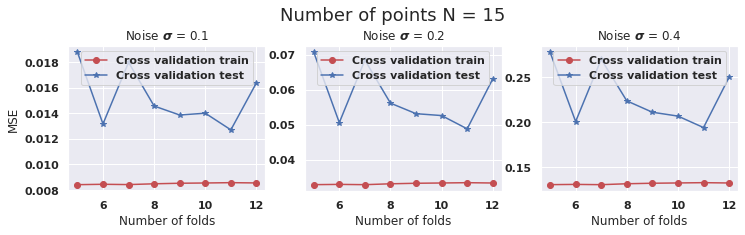

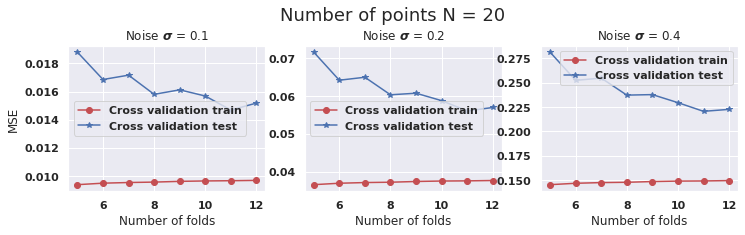

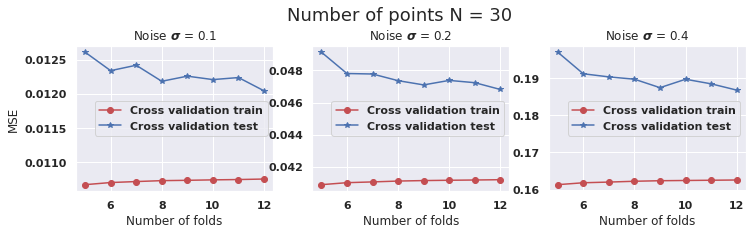

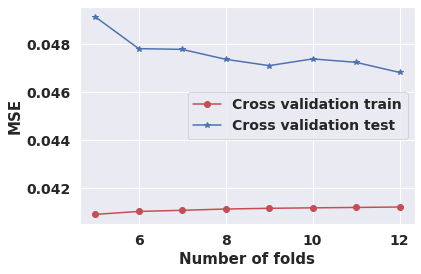

In [96]:
#maximum degree of polynomial
sel_degree = 7

k_folds = range(5,13)

#size of the initial dataset
nums_points = [15,20,30]

#std of the noise
noise_amps = [0.1,0.2,0.4]

#create arrays for results
MSE_cross = np.zeros((len(k_folds),2,len(noise_amps),len(nums_points)))



for j in range(len(nums_points)):
    
    fig,ax = plt.subplots(1,len(noise_amps),figsize=(12,3))
    fig.subplots_adjust(top=0.8)

    
    np.random.seed(53186)
    x0 = np.random.rand(nums_points[j])

    #set random seed
    np.random.seed(48643)
    y0 = np.random.rand(nums_points[j])

    #mesh arrays of x and y
    x,y = np.meshgrid(x0,y0)

    #create a dummy design matrix for the arrays of x and y
    X0 = create_X(x,y)
    
    
    for i in range(len(noise_amps)):

        
        np.random.seed(1231)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise


        #cycle on polynomial degrees
        X = create_X(x,y,sel_degree)
        
        for k in range(len(k_folds)):
            MSE_cross[k,0,i,j], MSE_cross[k,1,i,j] = cross_validation_OLS(k_folds[k],X,z)


        ax[i].plot(k_folds,MSE_cross[:,0, i, j],"o-",c="r",label="Cross validation train")
        ax[i].plot(k_folds,MSE_cross[:,1, i, j],"*-",c="b",label="Cross validation test")
        ax[i].set_xlabel('Number of folds')
        ax[0].set_ylabel('MSE',)
        #plt.setp(ax[i], ylim=(1e-3,0.3))
        #plt.setp(ax[i], yscale="log")
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        ax[i].legend()
        plt.suptitle("Number of points N = {}".format(nums_points[j]))

        
        
fig1, axis = plt.subplots(figsize=(6,4))
axis.plot(k_folds,MSE_cross[:,0, 1, 2],"o-",c="r",label="Cross validation train")
axis.plot(k_folds,MSE_cross[:,1, 1, 2],"*-",c="b",label="Cross validation test")
axis.set_xlabel('Number of folds',size=15,fontweight="bold")
axis.set_ylabel('MSE',size=15,fontweight="bold")
axis.tick_params(axis='both', labelsize=14)
axis.legend(prop={"size":14})
fig1.savefig("Pictures/CV_folds.png", bbox_inches='tight')



## Comparison of bootsrap and cross validation

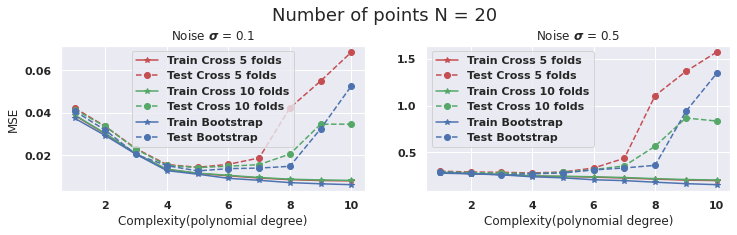

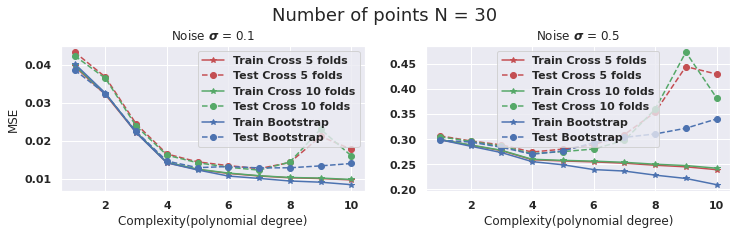

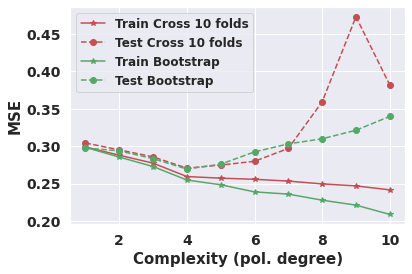

In [97]:
n_bs=100
maxdegree = 10

#size of the initial dataset
nums_points = [20,30]

#std of the noise
noise_amps = [0.1,0.5]

#possibility for k folds
k_folds = [5,10]

#create arrays for results
MSE_cross = np.zeros((maxdegree,len(k_folds),2,len(noise_amps),len(nums_points)))

MSE_boot = np.zeros((maxdegree,2,len(noise_amps),len(nums_points)))



for j in range(len(nums_points)):
    
    fig,ax = plt.subplots(1,len(noise_amps),figsize=(12,3))
    fig.subplots_adjust(top=0.8)

    
    np.random.seed(53186)
    x0 = np.random.rand(nums_points[j])

    #set random seed
    np.random.seed(48643)
    y0 = np.random.rand(nums_points[j])

    #mesh arrays of x and y
    x,y = np.meshgrid(x0,y0)

    #create a dummy design matrix for the arrays of x and y
    X0 = create_X(x,y)
    
    
    for i in range(len(noise_amps)):

        
        np.random.seed(1231)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise

        for degree in range(maxdegree):

            polydegree[degree] = degree+1
            
            X = create_X(x,y,degree+1)
            #X = MatrixScaler(X)

            X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
            z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train)

            _, z_pred, mse = bootstrap_OLS(X_train, X_test, z_train, z_test, n_bs )
            z_t = z_test.reshape(len(z_test),1)
            MSE_boot[degree,0,i, j] = np.mean(mse[:,0])
            MSE_boot[degree,1,i, j] = np.mean(mse[:,1])
            for l in range(len(k_folds)):
                k = k_folds[l]
                MSE_cross[degree,l,0,i, j],MSE_cross[degree,l,1,i, j] = cross_validation_OLS(k,X,z)

        ax[i].plot(range(1,maxdegree+1),MSE_cross[:,0,0, i, j],"r*-", label ='Train Cross 5 folds')
        ax[i].plot(range(1,maxdegree+1),MSE_cross[:,0,1, i, j],"ro--", label = 'Test Cross 5 folds')
        ax[i].plot(range(1,maxdegree+1),MSE_cross[:,1,0, i, j],"g*-", label ='Train Cross 10 folds')
        ax[i].plot(range(1,maxdegree+1),MSE_cross[:,1,1, i, j],"go--", label = 'Test Cross 10 folds')
        ax[i].plot(range(1,maxdegree+1),MSE_boot[:,0, i, j],"b*-",label = 'Train Bootstrap')
        ax[i].plot(range(1,maxdegree+1),MSE_boot[:,1, i, j],"bo--",label = 'Test Bootstrap')
        
        ax[i].set_xlabel('Complexity(polynomial degree)')
        ax[0].set_ylabel('MSE')
        #plt.setp(ax[i], ylim=(1e-3,0.3))
        #plt.setp(ax[i], yscale="log")
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        ax[i].legend()
        plt.suptitle("Number of points N = {}".format(nums_points[j]))

        
fig1, axis = plt.subplots(figsize=(6,4))

axis.plot(range(1,maxdegree+1),MSE_cross[:,1,0, 1, 1],"r*-", label ='Train Cross 10 folds')
axis.plot(range(1,maxdegree+1),MSE_cross[:,1,1, 1, 1],"ro--", label = 'Test Cross 10 folds')
axis.plot(range(1,maxdegree+1),MSE_boot[:,0, 1, 1],"g*-",label = 'Train Bootstrap')
axis.plot(range(1,maxdegree+1),MSE_boot[:,1, 1, 1],"go--",label = 'Test Bootstrap')
axis.set_xlabel('Complexity (pol. degree)',size=15,fontweight="bold")
axis.set_ylabel('MSE',size=15,fontweight="bold")
axis.tick_params(axis='both', labelsize=14)
axis.legend(prop={"size":12})
fig1.savefig("Pictures/BS_CV_OLS.png", bbox_inches='tight')



# Ridge

### Dependence on the regularization parameter

Lambda to obtain miminum MSE: 0.000000
Lambda to obtain miminum MSE: 0.007848


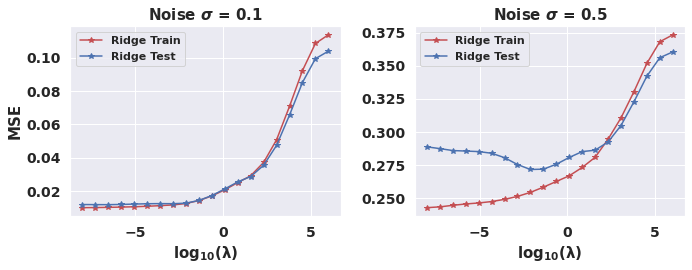

In [98]:
#number of points
num_points = 30

#different noise amplitudes
noise_amps = [0.1,0.5]

#degree of the polynomial
sel_degree = 8


#define interval of lambdas
nlambdas = 20
lambd = np.logspace(-8, 6, nlambdas)



np.random.seed(53186)
x0 = np.random.rand(num_points)

#set random seed
np.random.seed(48643)
y0 = np.random.rand(num_points)

#mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

#create a dummy design matrix for the arrays of x and y
X0 = create_X(x,y)


#setup design matrix with polynomial model
X = create_X(x,y,sel_degree)


MSE_Ridge = np.zeros((len(lambd),2,len(noise_amps)))


fig,ax = plt.subplots(1,len(noise_amps),figsize=(10,4))
fig.subplots_adjust(top=0.8)


for i in range(len(noise_amps)):

        
        np.random.seed(1231)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise


        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3,random_state=2)

        for l in range(len(lambd)):
    
            z_tilde_train, z_tilde_test = Ridge(X_train,X_test,z_train,z_test,lambd[l])

            MSE_Ridge[l,0,i] = mean_squared_error(z_train, z_tilde_train)
            MSE_Ridge[l,1,i] = mean_squared_error(z_test, z_tilde_test)

        
        fig.tight_layout(h_pad=1,w_pad=3)
        ax[i].plot(np.log10(lambd), MSE_Ridge[:,0,i], 'r*-', label = 'Ridge Train')
        ax[i].plot(np.log10(lambd), MSE_Ridge[:,1,i], 'b*-', label = 'Ridge Test')
        ax[i].tick_params(axis='both', labelsize=14)
        ax[i].set_xlabel('$\mathbf{log_{10}(\lambda)}$',size=15, fontweight="bold")
        ax[0].set_ylabel('MSE',size=15, fontweight="bold")
        #plt.setp(ax[i], ylim=(1e-3,0.3))
        #plt.setp(ax[i], yscale="log")
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        plt.setp(ax[i].title,size=15, fontweight="bold")
        ax[i].legend()
        #plt.suptitle("Number of points N = {}".format(num_points))
        print('Lambda to obtain miminum MSE: {:.6f}'.format(lambd[np.argmin(MSE_Ridge[:,1,i])]))
        
        fig.savefig("Pictures/Ridge_lambda.png")

## Bootstrapping method Ridge

### Bias - variance tradeoff

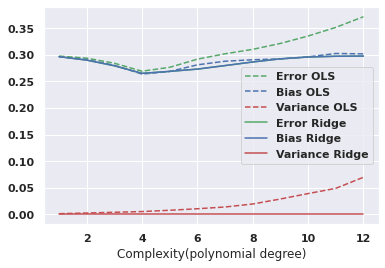

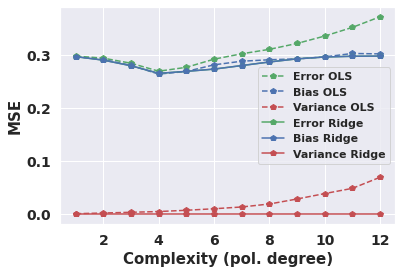

In [99]:
#number of points
num_points = 30

#noise amplitude
noise_amps = 0.5

#select value of lambda
lambd = 0.001438


maxdegree = 12

n_bootstrap = 100

#prepare arrays for output

error_ols = np.zeros(maxdegree)
bias_ols = np.zeros(maxdegree)
variance_ols = np.zeros(maxdegree)

error_ridge = np.zeros(maxdegree)
bias_ridge = np.zeros(maxdegree)
variance_ridge = np.zeros(maxdegree)

polydegree = np.zeros(maxdegree)

MSE_boot_ridge = np.zeros((maxdegree,2))
MSE_boot_ols = np.zeros((maxdegree,2))


#cycle on degrees of polynomial
for degree in range(maxdegree):
    
    
    
    #create design matrix (starting from degree 1)
    X = create_X(x,y,degree+1)
    #rescale design matrix

    np.random.seed(1231)
    noise = noise_amps*np.random.randn(X0.shape[0])

    #calculate starting target values with noise
    z = FrankeFunction(X0[:,1],X0[:,2]) + noise

    #train-test split
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
 
    z_train_ols, z_pred_ols, mse_ols = bootstrap_OLS(X_train, X_test,z_train, z_test, n_bootstrap)
    z_train_ridge, z_pred_ridge, mse_ridge = bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, lambd)
    
    #reshape test values
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree + 1
    
    #calculate error, bias, variance for Ridge regression
    error_ridge[degree] = np.mean( np.mean((z_t - z_pred_ridge)**2, axis=1, keepdims=True) )
    bias_ridge[degree] = np.mean( (z_t - np.mean(z_pred_ridge, axis=1, keepdims=True))**2 )
    variance_ridge[degree] = np.mean( np.var(z_pred_ridge, axis=1, keepdims=True) )
    
    #calculate error, bias, variance for OLS regression
    error_ols[degree] = np.mean( np.mean((z_t - z_pred_ols)**2, axis=1, keepdims=True) )
    bias_ols[degree] = np.mean( (z_t - np.mean(z_pred_ols, axis=1, keepdims=True))**2 )
    variance_ols[degree] = np.mean( np.var(z_pred_ols, axis=1, keepdims=True) )

    MSE_boot_ols[degree, 0] = np.mean(mse_ols[:,0]) 
    MSE_boot_ols[degree, 1] = np.mean(mse_ols[:,1]) 
    
    MSE_boot_ridge[degree, 0] = np.mean(mse_ridge[:,0]) 
    MSE_boot_ridge[degree, 1] = np.mean(mse_ridge[:,1])  
 
    
plt.plot(polydegree, error_ols, "--g" , label='Error OLS')
plt.plot(polydegree, bias_ols,"--b", label='Bias OLS')
plt.plot(polydegree, variance_ols, "--r", label='Variance OLS')

plt.plot(polydegree, error_ridge, "g", label='Error Ridge')
plt.plot(polydegree, bias_ridge, "b", label='Bias Ridge')
plt.plot(polydegree, variance_ridge, "r", label='Variance Ridge')

plt.xlabel('Complexity(polynomial degree)')

#plt.yscale("log")

plt.legend()
plt.show()


fig1, axis = plt.subplots(figsize=(6,4))
axis.plot(polydegree, error_ols, "p--g" , label='Error OLS')
axis.plot(polydegree, bias_ols,"p--b", label='Bias OLS')
axis.plot(polydegree, variance_ols, "p--r", label='Variance OLS')
axis.plot(polydegree, error_ridge, "g-p", label='Error Ridge')
axis.plot(polydegree, bias_ridge, "p-b", label='Bias Ridge')
axis.plot(polydegree, variance_ridge, "r-p", label='Variance Ridge')
axis.set_xlabel('Complexity (pol. degree)',size=15,fontweight="bold")
axis.set_ylabel('MSE',size=15,fontweight="bold")
axis.tick_params(axis='both', labelsize=14)
axis.legend(prop={"size":11})
fig1.savefig("Pictures/BV_Ridge_OLS.png", bbox_inches='tight')

### MSE analysis

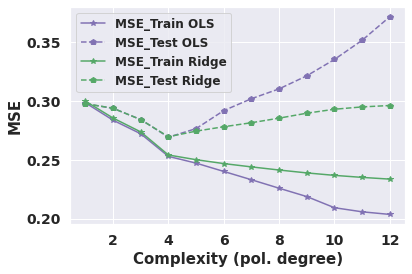

In [100]:
fig1, axis = plt.subplots(figsize=(6,4))

axis.plot(polydegree,MSE_boot_ols[:,0],"m*-",label='MSE_Train OLS')
axis.plot(polydegree,MSE_boot_ols[:,1],"mp--",label='MSE_Test OLS')
axis.plot(polydegree,MSE_boot_ridge[:,0],"g*-",label='MSE_Train Ridge')
axis.plot(polydegree,MSE_boot_ridge[:,1],"gp--",label='MSE_Test Ridge')
axis.set_xlabel('Complexity (pol. degree)',size=15,fontweight="bold")
axis.set_ylabel('MSE',size=15,fontweight="bold")
axis.tick_params(axis='both', labelsize=14)
axis.legend(prop={"size":12})
fig1.savefig("Pictures/BS_OLS_Ridge.png", bbox_inches='tight')

## Cross - validation Ridge

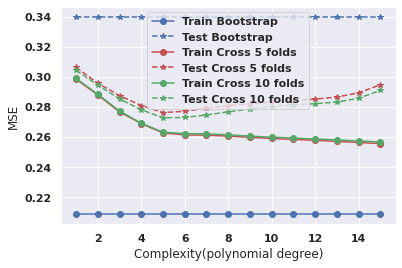

In [101]:
n_bs = 100

maxdegree = 15

MSE_train_boot = np.zeros(maxdegree)
MSE_test_boot = np.zeros(maxdegree)

k_folds = [5,10]

MSE_train_cross = np.zeros((maxdegree,2))
MSE_test_cross = np.zeros((maxdegree,2))

nlambdas = 18 
lambdas = np.logspace(-1,2, nlambdas)

mse_test_lambda = np.zeros(nlambdas)


for degree in range(maxdegree):
    
    X = create_X(x,y,degree+1)
    
    
    z = z.reshape(len(z),1)
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    for l in range(nlambdas):
        z_tilde_train, z_tilde_test = Ridge(X_train,X_test,z_train,z_test,lambdas[l])
        mse_test_lambda[l] = mean_squared_error(z_test, z_tilde_test)
        
    best_lambda[degree] = lambdas[np.argmin(mse_test_lambda)]
    
    z_train_ridge, z_pred_ridge, mse_ridge = bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, best_lambda[degree])
    MSE_train_boot[degree] = np.mean(mse[:,0])
    MSE_test_boot[degree] = np.mean(mse[:,1])
    
    for i  in range(len(k_folds)):
        k = k_folds[i]
        MSE_train_cross[degree,i],MSE_test_cross[degree,i] = cross_validation_Ridge(k,X,z,best_lambda[degree])

plt.figure()
plt.plot(range(1,maxdegree+1),MSE_train_boot,"bo-",label = 'Train Bootstrap')
plt.plot(range(1,maxdegree+1),MSE_test_boot,"b*--",label = 'Test Bootstrap')
plt.plot(range(1,maxdegree+1),MSE_train_cross[:,0],"ro-", label ='Train Cross 5 folds' )
plt.plot(range(1,maxdegree+1),MSE_test_cross[:,0],"r*--", label = 'Test Cross 5 folds' )
plt.plot(range(1,maxdegree+1),MSE_train_cross[:,1],"go-", label ='Train Cross 10 folds' )
plt.plot(range(1,maxdegree+1),MSE_test_cross[:,1],"g*--", label = 'Test Cross 10 folds' )
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Ridge Cross Validation

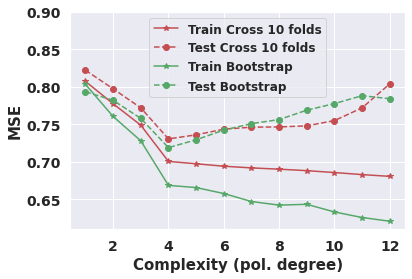

In [102]:
### With StandardScaler on input and target

def Ridge(X_train,X_test,z_train,z_test,lambd):

    # Since it relates to remove intercepts, better to use built in function in SKL
    RegRidge = linear_model.Ridge(lambd,fit_intercept= True)
    
    #fit the model to the training data
    RegRidge.fit(X_train,z_train)
    
    # and then make the prediction
    z_tilde_train = RegRidge.predict(X_train)
    z_tilde_test = RegRidge.predict(X_test)
    
    return z_tilde_train.reshape(len(z_tilde_train)), z_tilde_test.reshape(len(z_tilde_test))

def cross_validation_Ridge(k_folds, X, z, lambd):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_sc = scaler.transform(X_train)
        X_test_sc = scaler.transform(X_test)

        target_scaler = StandardScaler()
        target_scaler.fit(z_train)
        z_train_sc = target_scaler.transform(z_train)
        z_test_sc = target_scaler.transform(z_test)
        
        z_train_tilde_Ridge, z_test_tilde_Ridge = Ridge( X_train_sc, X_test_sc, z_train_sc, z_test_sc, lambd)
        
        MSE_train.append(mean_squared_error(z_train_sc, z_train_tilde_Ridge))
        MSE_test.append(mean_squared_error(z_test_sc, z_test_tilde_Ridge))
        
    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    return MSE_train_mean, MSE_test_mean

n_bs = 100

maxdegree = 12

MSE_train_boot = np.zeros(maxdegree)
MSE_test_boot = np.zeros(maxdegree)

k_folds = [5,10]

MSE_train_cross = np.zeros((maxdegree,2))
MSE_test_cross = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    X = create_X(x,y,degree+1)
    z = z.reshape(len(z),1)
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)

    target_scaler = StandardScaler()
    target_scaler.fit(z_train)
    z_train_sc = target_scaler.transform(z_train)
    z_test_sc = target_scaler.transform(z_test)
    
    z_train_tilde_Ridge , z_test_tilde_Ridge = Ridge(X_train_sc, X_test_sc, z_train, z_test,lambd)
    
    _, z_pred, mse = bootstrap_Ridge(X_train_sc, X_test_sc, z_train_sc, z_test_sc, n_bs, lambd)
    z_t = z_test_sc.reshape(len(z_test_sc),1)
    MSE_train_boot[degree] = np.mean(mse[:,0])
    MSE_test_boot[degree] = np.mean(mse[:,1])
    for i  in range(len(k_folds)):
        k = k_folds[i]
        MSE_train_cross[degree,i],MSE_test_cross[degree,i] = cross_validation_Ridge(k,X,z,lambd)

        

fig1, axis = plt.subplots(figsize=(6,4))

axis.plot(range(1,maxdegree+1),MSE_train_cross[:,1],"r*-", label ='Train Cross 10 folds' )
axis.plot(range(1,maxdegree+1),MSE_test_cross[:,1],"ro--", label = 'Test Cross 10 folds' )
axis.plot(range(1,maxdegree+1),MSE_train_boot,"g*-",label = 'Train Bootstrap')
axis.plot(range(1,maxdegree+1),MSE_test_boot,"go--",label = 'Test Bootstrap')
axis.set_xlabel('Complexity (pol. degree)',size=15,fontweight="bold")
axis.set_ylabel('MSE',size=15,fontweight="bold")
axis.tick_params(axis='both', labelsize=14)
axis.set_ylim(0.61,0.9)
axis.legend(prop={"size":12})
fig1.savefig("Pictures/BS_CV_Ridge.png", bbox_inches='tight')

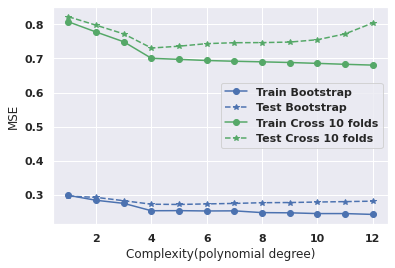

In [103]:
### Without StandardScaler

n_bs = 100

maxdegree = 12

MSE_train_boot = np.zeros(maxdegree)
MSE_test_boot = np.zeros(maxdegree)

k_folds = [5,10]

MSE_train_cross = np.zeros((maxdegree,2))
MSE_test_cross = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    X = create_X(x,y,degree+1)
    #X = MatrixScaler(X)
    
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    

    z_train_tilde_Ridge , z_test_tilde_Ridge = Ridge(X_train, X_test, z_train, z_test,lambd)
    
    _, z_pred, mse = bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bs, lambd)
    z_t = z_test.reshape(len(z_test),1)
    MSE_train_boot[degree] = np.mean(mse[:,0])
    MSE_test_boot[degree] = np.mean(mse[:,1])
    for i  in range(len(k_folds)):
        k = k_folds[i]
        MSE_train_cross[degree,i],MSE_test_cross[degree,i] = cross_validation_Ridge(k,X,z,lambd)

plt.figure()
plt.plot(range(1,maxdegree+1),MSE_train_boot,"bo-",label = 'Train Bootstrap')
plt.plot(range(1,maxdegree+1),MSE_test_boot,"b*--",label = 'Test Bootstrap')
plt.plot(range(1,maxdegree+1),MSE_train_cross[:,1],"go-", label ='Train Cross 10 folds' )
plt.plot(range(1,maxdegree+1),MSE_test_cross[:,1],"g*--", label = 'Test Cross 10 folds' )
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()


### Dependence on the number of folds

Text(0, 0.5, 'MSE')

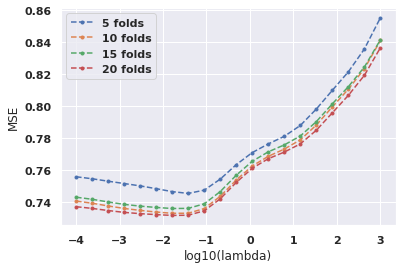

In [104]:
sel_degree = 5

X = create_X(x,y,sel_degree)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)

nlambdas = 20

lambd = np.logspace(-4, 3, nlambdas)

k_folds = np.arange(5,25,5)


MSE_test_CRidge = np.zeros((len(lambd), len(k_folds)))

for k in range(len(k_folds)):
    
    for i in range(len(lambd)):
        
        _, MSE_CRidge_test= cross_validation_Ridge(k_folds[k], X, z, lambd[i])
        MSE_test_CRidge[i,k] = MSE_CRidge_test # for test data set only

        
plt.figure()

for k in range(len(k_folds)):
    plt.plot(np.log10(lambd), MSE_test_CRidge[:,k], '.--', label= str(k_folds[k]) + ' folds')

plt.legend()
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')  

# 5. Boston Housing Data

In [146]:
boston_data = load_boston()
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df['MEDV'] = boston_data.target
features = boston_df.columns.tolist() 
print(features[:-1])
print("Size of data set: {} ".format(boston_df.shape))


## Feature selection
#x = drop_columns(boston_df,0.3)


x = boston_df.drop("MEDV",axis=1)
z = boston_df['MEDV']

#PCA
pca = PCA(n_components=0.95)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Size of data set: (506, 14) 


In [147]:
def drop_columns(boston_df, low_thresh, high_thresh=1, show=False):
    ''' Function takes in a value of thresholding and return the filtered dataframe, excluding already the target columns'''
    
    

    
    #print the correlation matrix
    corr_matrix = boston_df.corr().round(2)
    
    #show correlation matrix
    if show:
        sns.heatmap(data=corr_matrix, annot=True)
        
    array_corr = corr_matrix["MEDV"].abs()
    indices = np.arange(array_corr.shape[0])
    
    col_indi = indices[(array_corr < low_thresh) | (array_corr >= high_thresh)]
    
    display(corr_matrix)
    
    #eliminating colinearity by selecting only one of more highly correlated features
    
    #colinearity threshold
    colin_thresh = 0.75
    
    colin_vars = []
    
    for ind,col in itertools.product(corr_matrix.columns,corr_matrix.index):
        if (abs(corr_matrix[ind][col])>colin_thresh and ind !=col):
            colin_vars.append((ind,col))
            
    colin_used = []
    for (ind1,ind2) in colin_vars:
        if not (ind1 in colin_used or ind2 in colin_used):
            colin_used.append(ind1)
    print(colin_used)
    
    filtered_boston = boston_df.drop(boston_df.columns[col_indi], axis=1).drop(colin_used, axis=1)
    
    print(filtered_boston.columns,filtered_boston.shape)
    return filtered_boston



## OLS using no resampling method

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


['INDUS', 'NOX', 'RAD']
Index(['CRIM', 'ZN', 'RM', 'AGE', 'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='object') (506, 8)


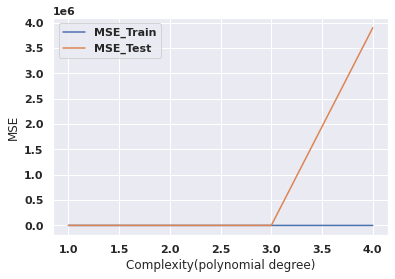

Minimum MSE reached : 15.3 
 for degree : 2.0


In [148]:
#degree of the polynomial model
maxdegree = 4

#target feature
z = boston_df['MEDV']

polydegree = np.zeros(maxdegree)
MSE_OLS = np.zeros((maxdegree,2))


x = drop_columns(boston_df,0.3)

for degree in range(maxdegree):
    
    #set up the model
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)
    
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)
     
    #z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train) 
    
    MSE_OLS[degree, 0] = mean_squared_error(z_train,z_train_tilde_ols)
    MSE_OLS[degree, 1] = mean_squared_error(z_test,z_test_tilde_ols)  

#plot the results
plt.figure()
plt.plot(polydegree,MSE_OLS[:,0],label='MSE_Train')
plt.plot(polydegree,MSE_OLS[:,1],label='MSE_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
#plt.yscale("log")
plt.legend()
plt.show()

print("Minimum MSE reached : {:.1f} \n for degree : {}".format(np.min(MSE_OLS[:,1]),polydegree[np.argmin(MSE_OLS[:,1])]))

## OLS with resampling methods

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


['INDUS', 'NOX', 'RAD']
Index(['CRIM', 'ZN', 'RM', 'AGE', 'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='object') (506, 8)


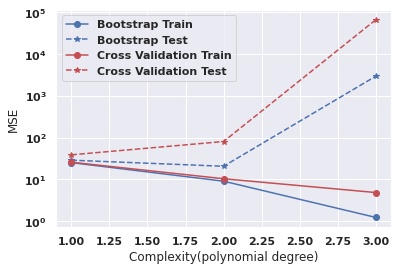

Bootstrap: 
 Minimum MSE reached : 20.5 
 for degree : 2.0

CV: 
 Minimum MSE reached : 38.5 
 for degree : 1.0



In [149]:
#degree of the polynomial model
maxdegree = 3

n_bs = 200

k_folds = 8

#target feature
z = boston_df['MEDV']

x = drop_columns(boston_df,0.3)

polydegree = np.zeros(maxdegree)
MSE_boot = np.zeros((maxdegree,2))
MSE_cv = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    #set up the model
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)
    
    scaler = StandardScaler()
    scaler.fit(X)
    X_sc = scaler.transform(X)
    
    X_train, X_test, z_train, z_test = train_test_split(np.array(X), np.array(z), test_size=0.3, random_state = 2)
    
    #scaler = StandardScaler()
    #scaler.fit(X_train)
    #X_train= scaler.transform(X_train)
    #X_test = scaler.transform(X_test)
    
    #z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    
    z_train_tilde_ols , z_test_tilde_ols, MSE_boot_deg = bootstrap_OLS(X_train, X_test, z_train, z_test, n_bs) 
    
    MSE_boot[degree, 0] = np.mean(MSE_boot_deg[:,0])
    MSE_boot[degree, 1] = np.mean(MSE_boot_deg[:,1])
    
    MSE_cv[degree, 0], MSE_cv[degree, 1] = cross_validation_OLS(k_folds,X,z)
     

#plot the results
plt.plot(polydegree,MSE_boot[:,0],"bo-",label='Bootstrap Train')
plt.plot(polydegree,MSE_boot[:,1],"b*--",label='Bootstrap Test')
plt.plot(polydegree,MSE_cv[:,0],"ro-",label='Cross Validation Train')
plt.plot(polydegree,MSE_cv[:,1],"r*--",label='Cross Validation Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend()
plt.show()




print("Bootstrap: \n Minimum MSE reached : {:.1f} \n for degree : {}\n".format(np.min(MSE_boot[:,1]),polydegree[np.argmin(MSE_boot[:,1])]))


print("CV: \n Minimum MSE reached : {:.1f} \n for degree : {}\n".format(np.min(MSE_cv[:,1]),polydegree[np.argmin(MSE_cv[:,1])]))


## Ridge regression without resampling methods

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


['INDUS', 'NOX', 'RAD']
Index(['CRIM', 'ZN', 'RM', 'AGE', 'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='object') (506, 8)
Minimum MSE reached : 11.6 
 for lambda : 0.3088843596477482



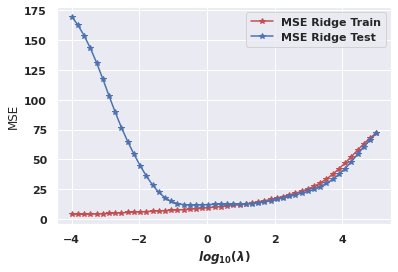

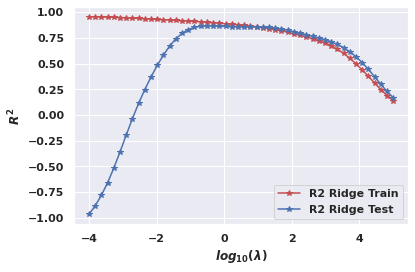

In [150]:
def Ridge_regression(X_train,X_test,z_train,z_test,lamb):
    df=pd.DataFrame(X_train)
    col=len(df.columns)
    I = np.eye(col,col)
    
    
    train_mean = X_train.mean(axis=0)
    
    X_train = X_train - train_mean
    X_test = X_test - train_mean
    
    
    Ridgebeta = np.linalg.pinv(X_train.T @ X_train+lamb*I) @ X_train.T @ z_train
    
    z_train_pre = X_train @ Ridgebeta
    z_test_pre = X_test @ Ridgebeta
    
    return z_train_pre, z_test_pre

def Ridge(X_train,X_test,z_train,z_test,lambd):

    # Since it relates to remove intercepts, better to use built in function in SKL
    RegRidge = linear_model.Ridge(lambd,fit_intercept= True)
    
    #fit the model to the training data
    RegRidge.fit(X_train,z_train)
    
    # and then make the prediction
    z_tilde_train = RegRidge.predict(X_train)
    z_tilde_test = RegRidge.predict(X_test)
    
    return z_tilde_train, z_tilde_test


z = boston_df['MEDV']
x = drop_columns(boston_df,0.3)


#Let's apply the Ridge regression

sel_degree = 2
nlambdas = 50 
lambd = np.logspace(-4,5, nlambdas)

MSE_Ridge = np.zeros((len(lambd),2))
R2_Ridge = np.zeros((len(lambd),2))


#set up the model
poly = PolynomialFeatures(sel_degree+1)

X = poly.fit_transform(x)

X_train, X_test, z_train, z_test = train_test_split(np.array(X), np.array(z), test_size=0.3, random_state = 2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

for i in range(nlambdas):
    z_tilde_train, z_tilde_test = Ridge(X_train,X_test,z_train,z_test,lambd[i])
    MSE_Ridge[i,0] = mean_squared_error(z_train, z_tilde_train)
    MSE_Ridge[i,1] = mean_squared_error(z_test, z_tilde_test)
    R2_Ridge[i, 0] = r2_score(z_train, z_tilde_train)
    R2_Ridge[i, 1] = r2_score(z_test, z_tilde_test)
    #print(MSE_Ridge[i,1])
        
plt.figure()
plt.plot(np.log10(lambd), MSE_Ridge[:,0], 'r*-', label = 'MSE Ridge Train')
plt.plot(np.log10(lambd), MSE_Ridge[:,1], 'b*-', label = 'MSE Ridge Test')
plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('MSE')
plt.legend()
#print('Lambda to obtain miminum MSE: {:.2f}'.format(lambd[np.argmin(MSE_Ridge[:,1])]))


print("Minimum MSE reached : {:.1f} \n for lambda : {}\n".format(np.min(MSE_Ridge[:,1]),lambd[np.argmin(MSE_Ridge[:,1])]))



plt.figure()
plt.plot(np.log10(lambd), R2_Ridge[:,0], 'r*-', label = 'R2 Ridge Train')
plt.plot(np.log10(lambd), R2_Ridge[:,1], 'b*-', label = 'R2 Ridge Test')
plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('$R^2$')

plt.legend()
plt.show()


In [ ]:
maxdegree = 8

nlambdas = 50 
lambdas = np.logspace(-1,2, nlambdas)


polydegree = np.zeros(maxdegree)

best_lambda = np.zeros(maxdegree)

mse_test_lambda = np.zeros(nlambdas)

MSE_ridge = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)
    
    #train-test split
    X_train, X_test, z_train, z_test = train_test_split(np.array(X), np.array(z), test_size=0.3, random_state = 2)
 
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
   # target_scaler = StandardScaler()
   # target_scaler.fit(z_train.reshape(1, -1))
    #z_train = target_scaler.transform(z_train.reshape(1, -1))
   # z_test = target_scaler.transform(z_test.reshape(1, -1))

    for i in range(nlambdas):
        z_tilde_train, z_tilde_test = Ridge(X_train,X_test,z_train,z_test,lambdas[i])
        mse_test_lambda[i] = mean_squared_error(z_test, z_tilde_test)
        
    best_lambda[degree] = lambdas[np.argmin(mse_test_lambda)]
   # print(best_lambda)
    
    z_tilde_train, z_tilde_test = Ridge(X_train,X_test,z_train,z_test,best_lambda[degree])
    
    polydegree[degree] = degree + 1

    MSE_ridge[degree, 0] = mean_squared_error(z_tilde_train,z_train)
    MSE_ridge[degree, 1] = mean_squared_error(z_tilde_test,z_test)
    

plt.figure(figsize=(7,5))
plt.plot(polydegree, MSE_ridge[:, 0], "y", label='MSE Train')
plt.plot(polydegree, MSE_ridge[:, 1], "c", label='MSE Test')

print("Bootstrap: \n Minimum MSE reached : {:.1f} \n for degree : {}\n and lambda : {:}".format(np.min(MSE_ridge[:,1]),polydegree[np.argmin(MSE_ridge[:,1])],best_lambda[np.argmin(MSE_ridge[:,1])]))

plt.xlabel('Complexity(polynomial degree)')
#plt.yscale("log")
plt.legend()
plt.show()

## Ridge regression with resampling methods

In [ ]:
#Bootstrap-Ridge
maxdegree = 5

nlambdas = 30 
lambdas = np.logspace(-1,2, nlambdas)

n_bootstrap = 50

error_ridge = np.zeros(maxdegree)
bias_ridge = np.zeros(maxdegree)
variance_ridge = np.zeros(maxdegree)

polydegree = np.zeros(maxdegree)

best_lambda = np.zeros(maxdegree)

mse_test_lambda = np.zeros(nlambdas)

MSE_boot_ridge = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)

    
    #train-test split
    X_train, X_test, z_train, z_test = train_test_split(np.array(X), np.array(z), test_size=0.3, random_state = 2)
 
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    for i in range(nlambdas):
        _,_, mse_ridge = bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, lambdas[i])
        mse_test_lambda[i] = np.mean(mse_ridge[:,1])
    
    best_lambda[degree] = lambdas[np.argmin(mse_test_lambda)]
    
    z_train_ridge, z_pred_ridge, mse_ridge = bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, best_lambda[degree])
    
    
    #reshape test values
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree + 1
    
    MSE_boot_ridge[degree, 0] = np.mean(mse_ridge[:,0]) 
    MSE_boot_ridge[degree, 1] = np.mean(mse_ridge[:,1]) 
    

plt.figure(figsize=(7,5))
plt.plot(polydegree, MSE_boot_ridge[:, 0], "y", label='MSE Train')
plt.plot(polydegree, MSE_boot_ridge[:, 1], "c", label='MSE Test')



print("Bootstrap: \n Minimum MSE reached : {:.1f} \n for degree : {}\n and lambda : {:.2f}".format(np.min(MSE_boot_ridge[:,1]),polydegree[np.argmin(MSE_boot_ridge[:,1])],best_lambda[np.argmin(MSE_boot_ridge[:,1])]))

plt.xlabel('Complexity(polynomial degree)')
#plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
def cross_validation_Ridge(k_folds, X, z, lambd):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)

    for train_inds, test_inds in kfold.split(X):
        
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_sc = scaler.transform(X_train)
        X_test_sc = scaler.transform(X_test)
        
        
        z_train_tilde_Ridge, z_test_tilde_Ridge = Ridge( X_train_sc, X_test_sc, z_train, z_test, lambd)
        
        MSE_train.append(mean_squared_error(z_train, z_train_tilde_Ridge))
        MSE_test.append(mean_squared_error(z_test, z_test_tilde_Ridge))

    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    
    return MSE_train_mean, MSE_test_mean



#Cross-Validation
maxdegree = 4

k_folds = 10

nlambdas = 30 
lambdas = np.logspace(-1,2, nlambdas)

MSE_cross_Ridge = np.zeros((maxdegree,2))

mse_test_lambda = np.zeros(nlambdas)

for degree in range(maxdegree):
    
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)
    

    for i in range(nlambdas):
        _, mse_test_lambda[i] = cross_validation_Ridge(k_folds,X,z,lambdas[i])
    
    best_lambda[degree] = lambdas[np.argmin(mse_test_lambda)]
    
    MSE_cross_Ridge[degree,0], MSE_cross_Ridge[degree,1]  = cross_validation_Ridge(k_folds,X,z,best_lambda[degree])
    

plt.plot(range(1,maxdegree+1),MSE_cross_Ridge[:,0], 'r*-', label = 'MSE Ridge Train')
plt.plot(range(1,maxdegree+1),MSE_cross_Ridge[:,1], 'b*-', label = 'MSE Ridge Test')
plt.xlabel('Complexity(polynomial degree')
plt.ylabel('MSE')
plt.legend()

print("CV: \n Minimum MSE reached : {:.1f} \n for degree : {}\n and lambda : {:.2f}".format(np.min(MSE_cross_Ridge[:,1]),polydegree[np.argmin(MSE_cross_Ridge[:,1])],best_lambda[np.argmin(MSE_cross_Ridge[:,1])]))


In [ ]:
plt.plot(range(1,maxdegree+1),MSE_cross_Ridge[:,0], 'r*-', label = 'MSE Ridge Train')
plt.plot(range(1,maxdegree+1),MSE_cross_Ridge[:,1], 'b*-', label = 'MSE Ridge Test')
plt.xlabel('Complexity(polynomial degree')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend()

print("CV: \n Minimum MSE reached : {:.1f} \n for degree : {}\n and lambda : {:.2f}".format(np.min(MSE_cross_Ridge[:,1]),polydegree[np.argmin(MSE_cross_Ridge[:,1])],best_lambda[np.argmin(MSE_cross_Ridge[:,1])]))
print(MSE_cross_Ridge[:,1])